In [70]:
# TensorFlow and tf.keras
import json
import tensorflow as tf
#from tensorflow.keras.layers import *
#from tensorflow.keras.models import *
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# Helper libraries
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

from datetime import datetime
from packaging import version

################################################################################
#num_trials = 3

# Input Dimension of the model
input_dimension = 2

# Task 2 parameter
delta_width = 0.5

# Is distal orthogonality guaranteed?
#distal_orthogonality = False

# Randomly chosen learning rate
random_learning_rate = np.random.rand()*0.01+1e-6

# Number of epochs of training
epochs = 50

# Minibatch Size
batch_size_param = 100

# Total Number of Data Points in Training, Validation, and Test Sets
num_data = 10000

# Gaussian Noise Added to Training Data with randomly chosen variance
noise_level = np.random.exponential(scale=1., size=None)

# Task 1 parameter
number_of_RBF_exponentials = 1000

############################################################################

def Task_1_Target_Function_RBF(x):
    batch_size = len(x)
    #dimension  = x.shape[-1]
    differences = x.reshape(batch_size,input_dimension,1)-RBF_locations
    v0 = random_weights*np.exp(
        -RBF_scale*np.sqrt(np.sum((differences)**2,axis=1,keepdims=False)))
    v1 = np.sum(v0,axis=1,keepdims=False)
    return v1

def Task_2_Target_Function(x):
    
    batch_size = len(x)
    #dimension  = x.shape[-1]
    differences = x.reshape(batch_size,input_dimension,1)-task2_RBF_locations
    v0 = task2_random_weights*np.exp(
        -task2_RBF_scale*np.sqrt(np.sum((differences)**2,axis=1,keepdims=False)))
    v1 = np.sum(v0,axis=1,keepdims=False)
    
    a = (np.prod((np.heaviside(x-task2_position,0.5)*np.heaviside(task2_position-x+delta_width,0.5)), 
        axis=1,keepdims=False))
    
    return (1.-a)*Task_1_Target_Function_RBF(x) + a*v1

def cubic_spline(x):
    
    "Activation function to implement the basis functions"
    
    y0 = K.switch(tf.logical_and(tf.zeros(tf.shape(x))<=x, x<tf.ones(tf.shape(x))), 
                 x**3/6, 
                 tf.zeros(tf.shape(x))
                )
    
    y1 = K.switch(tf.logical_and(tf.ones(tf.shape(x))<=x, x<2*tf.ones(tf.shape(x))),
                 (-3.*(x-1.)**3 +3.*(x-1.)**2 + 3*(x-1.)+1.)/6.,
                 tf.zeros(tf.shape(x))
                )
    
    y2 = K.switch(tf.logical_and(tf.ones(tf.shape(x))*2<=x, x<3*tf.ones(tf.shape(x))),
                 (3*(x-2)**3 - 6*(x-2)**2 + 4. )/6.,
                 tf.zeros(tf.shape(x))
                )

    y3 = K.switch(tf.logical_and(tf.ones(tf.shape(x))*3<=x, x<4*tf.ones(tf.shape(x))),
                 ( 4. -x)**3/6.,
                 tf.zeros(tf.shape(x))
                )    
    
    y  = y0 + y1 + y2 + y3
    
    return y

def floormod_activation(x):
    return tf.math.floormod(x, 1.)

def embedding_b(n,r):
    
    v = (np.arange(0,n).reshape(n,1))*(4*2**np.arange(0,r))

    for j in range(1,r):
        v[:,j] = v[:,j]+ n*(4*2**np.arange(0,r))[:j].sum()
    
    return v.reshape(n*r)

def embedding_s(n,r):
    
    return embedding_b(n,r)[-1] + (4*2**(r-1))

def exponential_bias(m,k,d):
    """ The dampening factor d should be roughly 7 times n """
    v = np.zeros((k,2*m))
    for i in range(0,m):
        factor = (i+1)**2
        log_val = -np.log(factor) - d
        v[:,2*i] = log_val
        v[:,2*i+1] = log_val
    return v.reshape(2*k*m,)

def exponential_w(m):
    u0 = 1.*np.ones(m)
    u1 = -1.*np.ones(m)
    return np.ravel([u0,u1],'F').astype('float32').reshape(2*m,1)

import tensorboard
print(tensorboard.__version__)

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

#Load the TensorBoard notebook extension.
%load_ext tensorboard

################################################################################
# ATLAS via subclassing
class ATLAS(keras.Model):
    """ """
    def __init__(self, n, m, r, k, h0, distal_orthogonality):
        super(ATLAS, self).__init__()
        ################################################################################
        #tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
        #tf.constant_initializer(0.)
        ################################################################################
        self.n = n
        self.m = m
        self.r = r
        self.k = k
        self.h0 = h0
        self.distal_orthogonality = distal_orthogonality #Boolean
        ################################################################################
        self.reshape_inp = tf.keras.layers.Reshape((self.n,1))
        ################################################################################
        # The adaptive maximum density splines
        self.a00 = tf.keras.layers.Conv1D(
                                filters=1, 
                                kernel_size=1,
                                strides=1, padding='valid',
                                data_format='channels_last', 
                                dilation_rate=1,
                                activation=None, 
                                use_bias=False,
                                trainable=False,
                                kernel_initializer=tf.constant_initializer((4*2**(self.r))-3))
        ################################################################################        
        # Adaptive maximum density splines
        self.a10 = tf.keras.layers.Activation(floormod_activation)
        # no reshape necessary
        self.a20 = tf.keras.layers.Conv1D(
                                filters=4, 
                                kernel_size=1,
                                strides=1, padding='valid',
                                data_format='channels_last', 
                                dilation_rate=1,
                                activation=cubic_spline, 
                                use_bias=True,
                                trainable=False,
                                kernel_initializer=tf.constant_initializer(1.),
                                bias_initializer=tf.constant_initializer((3-np.arange(0,4))))
        self.a30 = tf.keras.layers.Reshape((self.n*4,))
        ################################################################################
        self.asa = tf.keras.layers.RepeatVector(self.k)
        ################################################################################        
        self.a01 = tf.keras.layers.Activation(tf.math.floor)
        self.a02 = tf.keras.layers.Reshape((self.n,))
        self.a03 = np.arange(0.,self.n)*(4*2**self.r)
        self.a04 = tf.keras.layers.Reshape((self.n,1))
        self.a05 = tf.keras.layers.Conv1D(
                                filters=4, 
                                kernel_size=1,
                                strides=1, padding='valid',
                                data_format='channels_last', 
                                dilation_rate=1,
                                activation=None, 
                                use_bias=True,
                                trainable=False,
                                kernel_initializer=tf.constant_initializer(1),
                                bias_initializer=tf.constant_initializer(np.arange(0,4)),
                                dtype=tf.float32)
        self.a06 = tf.keras.layers.Reshape((self.n*4,))
        ################################################################################
        self.aea = tf.keras.layers.Embedding(
                                input_dim=self.n*(4*2**self.r),
                                output_dim=self.k,
                                input_length=self.n,
                                embeddings_initializer='zero',
                                trainable=True)
        ################################################################################
        # Exponential terms
        if self.m > 0:
            self.ase = tf.keras.layers.RepeatVector(2*self.m*self.k)
            self.aee = tf.keras.layers.Embedding(
                                    input_dim=self.n*(4*2**self.r),
                                    output_dim=2*self.m*self.k,
                                    input_length=self.n, 
                                    embeddings_initializer='zero',
                                    trainable=True)
            
            self.e1 = exponential_bias(self.m,self.k,10.)
            self.e2 = tf.keras.layers.Activation(tf.math.exp)
            self.e3 = tf.keras.layers.Reshape((k,2*m))
            self.e4 = tf.keras.layers.Dense(units=1,
                                            use_bias=False,
                                            trainable=False,
                                            kernel_initializer=tf.constant_initializer(exponential_w(m)))
            self.e5 = tf.keras.layers.Reshape((k,))
            
        ################################################################################
        # Core layers
        if self.r > 0:
            self.c00 = tf.keras.layers.Conv1D(
                                    filters=self.r, 
                                    kernel_size=1,
                                    strides=1, padding='valid',
                                    data_format='channels_last', 
                                    dilation_rate=1,
                                    activation=None, 
                                    use_bias=False,
                                    trainable=False,
                                    kernel_initializer=tf.constant_initializer(4*2**np.arange(0.,self.r)-3))
            ################################################################################
            self.c10 = tf.keras.layers.Activation(floormod_activation)
            self.c20 = tf.keras.layers.Reshape((self.n,self.r,1))
            self.c30 = tf.keras.layers.Conv1D(
                                    filters=4, 
                                    kernel_size=1,
                                    strides=1, padding='valid',
                                    data_format='channels_last', 
                                    dilation_rate=1,
                                    activation=cubic_spline, 
                                    use_bias=True,
                                    trainable=False,
                                    kernel_initializer=tf.constant_initializer(1.),
                                    bias_initializer=tf.constant_initializer((3-np.arange(0,4))))
            self.c40 = tf.keras.layers.Reshape((self.n*self.r*4,))
            ################################################################################
            self.csa = tf.keras.layers.RepeatVector(self.k)
            ################################################################################
            self.c01 = tf.keras.layers.Activation(tf.math.floor)
            self.c02 = tf.keras.layers.Reshape((self.n*self.r,))
            self.c03 = embedding_b(n,r)
            self.c04 = tf.keras.layers.Reshape((self.n,self.r,1))
            self.c05 = tf.keras.layers.Conv1D(
                                    filters=4, 
                                    kernel_size=1,
                                    strides=1, padding='valid',
                                    data_format='channels_last', 
                                    dilation_rate=1,
                                    activation=None, 
                                    use_bias=True,
                                    trainable=False,
                                    kernel_initializer=tf.constant_initializer(1),
                                    bias_initializer=tf.constant_initializer(np.arange(0,4)),
                                    dtype=tf.float32)
            self.c06 = tf.keras.layers.Reshape((self.n*self.r*4,))
            ################################################################################
            self.cea = tf.keras.layers.Embedding(
                                    input_dim=embedding_s(self.n,self.r),
                                    output_dim=self.k,
                                    input_length=self.n,
                                    embeddings_initializer='zero',
                                    trainable=not(self.distal_orthogonality)) #edit
        ################################################################################
        # Exponential terms
        if ((self.r > 0) and (self.m > 0)):
            self.cse = tf.keras.layers.RepeatVector(2*self.m*self.k)
            self.cee = tf.keras.layers.Embedding(
                                    input_dim=embedding_s(self.n,self.r),
                                    output_dim=2*self.m*self.k,
                                    input_length=self.n,
                                    embeddings_initializer='zero',
                                    trainable=not(self.distal_orthogonality)) #edit
        ################################################################################
        
    def call(self, input_tensor, training=False):
        
        inp = self.reshape_inp(input_tensor)
        A00 = self.a00(inp)
        AZ0 = self.a30(self.a20(self.a10(A00)))
        A0Z = self.a06(self.a05(self.a04(tf.nn.bias_add(self.a02(self.a01(A00)),self.a03))))
        asa = tf.transpose(self.asa(AZ0),perm=[0, 2, 1])
        aea = self.aea(A0Z)
        AA  = tf.math.reduce_sum(tf.keras.layers.Multiply()([asa,aea]),1,keepdims=False)
        if self.r == 0:
            if self.m == 0:
                out = AA
                return out
            elif self.m > 0:
                ase = tf.transpose(self.ase(AZ0),perm=[0, 2, 1])
                aee = self.aee(A0Z)
                AE  = tf.math.reduce_sum(tf.keras.layers.Multiply()([ase,aee]),1,keepdims=False)
                EX0 = AE #tf.keras.layers.Add()([CE,AE])
                EX  = self.e5(self.e4(self.e3(self.e2(tf.nn.bias_add(EX0,self.e1)))))
                out = tf.keras.layers.Add()([AA,EX])
                return out
        elif self.r > 0:
            if self.m == 0:
                C00 = self.c00(inp)
                CZ0 = self.c40(self.c30(self.c20(self.c10(C00))))
                C0Z = self.c06(self.c05(self.c04( tf.nn.bias_add(self.c02(self.c01(C00)),self.c03))))
                csa = tf.transpose(self.csa(CZ0),perm=[0, 2, 1])
                cea = self.cea(C0Z)
                CA  = tf.math.reduce_sum(tf.keras.layers.Multiply()([csa,cea]),1,keepdims=False)
                out = tf.keras.layers.Add()([AA,CA])
                return out
            elif self.m > 0:
                C00 = self.c00(inp)
                CZ0 = self.c40(self.c30(self.c20(self.c10(C00))))
                C0Z = self.c06(self.c05(self.c04( tf.nn.bias_add(self.c02(self.c01(C00)),self.c03))))
                csa = tf.transpose(self.csa(CZ0),perm=[0, 2, 1])
                cea = self.cea(C0Z)
                CA  = tf.math.reduce_sum(tf.keras.layers.Multiply()([csa,cea]),1,keepdims=False)
                ase = tf.transpose(self.ase(AZ0),perm=[0, 2, 1])
                aee = self.aee(A0Z)
                AE  = tf.math.reduce_sum(tf.keras.layers.Multiply()([ase,aee]),1,keepdims=False)
                cse = tf.transpose(self.cse(CZ0),perm=[0, 2, 1])
                cee = self.cee(C0Z)
                CE  = tf.math.reduce_sum(tf.keras.layers.Multiply()([cse,cee]),1,keepdims=False)
                EX0 = tf.keras.layers.Add()([CE,AE])
                EX  = self.e5(self.e4(self.e3(self.e2(tf.nn.bias_add(EX0,self.e1)))))
                out = tf.keras.layers.Add()([AA,CA,EX])
                return out
        
    def construct(self):
        self(tf.keras.layers.Input(shape=(self.n,)))
        
############################################################################
# Grid plot for images

resolution = 0.01
x0 = np.arange(0.,1., resolution)
x1 = np.arange(0.,1., resolution)
array_grid = np.array(np.meshgrid(x0, x1))
x0 = np.arange(0.,1., resolution)
x1 = np.arange(0.,1., resolution)
x0, x1 = np.meshgrid(x0, x1)
coordinates = np.array([x0.flatten(),x1.flatten()]).transpose()

################################################################################

if input_dimension > 2:
    Random_Slice = np.random.rand(input_dimension)
    Expanded_Coordinates = np.zeros((10000,input_dimension))
    Expanded_Coordinates[:,2:] = Random_Slice[2:]
    Expanded_Coordinates[:,:2] = coordinates
    coordinates = Expanded_Coordinates

############################################################################
# Plotting 1D slices of functions as a single-variable function of a parameter
# connecting two uniformly random points in R^{n>1}, for the single-variable case
# we simply plot the unit interval

def line_element_generator():
    point_1 = np.random.rand(input_dimension,1)
    point_2 = np.random.rand(input_dimension,1)
    line_elements =(point_1*(np.linspace(0,1,100).reshape(1,100))).T \
                    +(point_2*(1.-np.linspace(0,1,100)).reshape(1,100)).T
    return line_elements


2.8.0
TensorFlow version:  2.8.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [78]:
############################################################################
# Randomly Generaed parameters for the target functions
# Task 1
RBF_locations = np.random.rand(1,input_dimension,number_of_RBF_exponentials)
RBF_scale = np.random.exponential(scale=10., size=number_of_RBF_exponentials)
random_weights = np.random.randn(number_of_RBF_exponentials)
# Task 2ga
task2_position = np.random.rand(input_dimension)*(1-delta_width)
task2_RBF_locations = np.random.rand(1,input_dimension,number_of_RBF_exponentials)
task2_RBF_scale = np.random.exponential(scale=10., size=number_of_RBF_exponentials)
task2_random_weights = np.random.randn(number_of_RBF_exponentials)


In [79]:
############################################################################
# Data for Task 1
Task_1_train_inputs = np.random.rand(num_data, input_dimension)
Task_1_train_output =  Task_1_Target_Function_RBF(Task_1_train_inputs) \
                        + noise_level*np.random.randn(num_data)

Task_1_validation_inputs = np.random.rand(num_data, input_dimension)
Task_1_validation_output =  Task_1_Target_Function_RBF(Task_1_validation_inputs) \
                            +noise_level*np.random.randn(num_data)

Task_1_test_inputs = np.random.rand(num_data, input_dimension)
Task_1_test_output = Task_1_Target_Function_RBF(Task_1_test_inputs) \
                            +noise_level*np.random.randn(num_data)

############################################################################
# Data for Task 2
Task_2_train_inputs = np.random.rand(num_data, input_dimension)*delta_width + task2_position
Task_2_train_output =  Task_2_Target_Function(Task_2_train_inputs) \
                        + noise_level*np.random.randn(num_data)

Task_2_validation_inputs = np.random.rand(num_data, input_dimension)
Task_2_validation_output =  Task_2_Target_Function(Task_2_validation_inputs) \
                            +noise_level*np.random.randn(num_data)

Task_2_test_inputs = np.random.rand(num_data, input_dimension)
Task_2_test_output = Task_2_Target_Function(Task_2_test_inputs) \
                            +noise_level*np.random.randn(num_data)


In [80]:
############################################################################
# Plotting 1D slices of functions as a single-variable function of a parameter
# connecting two uniformly random points in R^{n>1}, for the single-variable case
# we simply plot the unit interval

if input_dimension>1:
    line_parameter = np.linspace(0,0.999,100)
    line_elements_list = [line_element_generator() for i in range(0,3)]
    
elif input_dimension == 1:
    line_parameter = np.linspace(0.,0.999,100)
    line_elements_list = [line_parameter.reshape(100,1)]
    

In [81]:
print(random_learning_rate)

0.006259426624470359


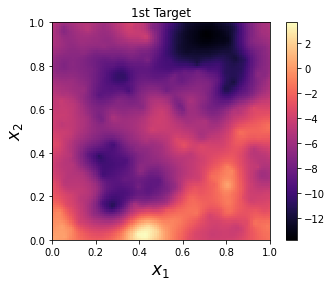

In [82]:
if input_dimension > 1:
    Task_1_Target = Task_1_Target_Function_RBF(coordinates).reshape(100,100)

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_1_Target,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('1st Target')
    plt.show()

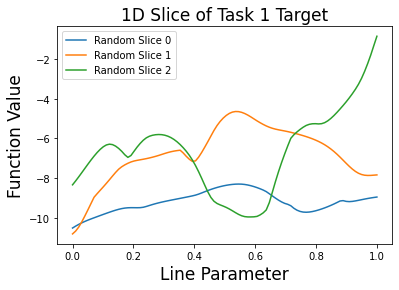

In [83]:
for index in range(0,len(line_elements_list)):
    line_or_path = line_elements_list[index]
    plt.plot(line_parameter, 
             Task_1_Target_Function_RBF(line_or_path), 
             label= "Random Slice "+str(index))
    plt.legend()
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('1D Slice of Task 1 Target',fontsize=17)
plt.show()

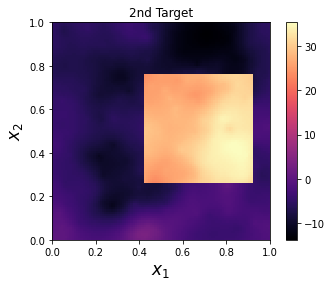

In [84]:
if input_dimension > 1:
    Task_2_Target = Task_2_Target_Function(coordinates).reshape(100,100)

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_2_Target,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('2nd Target')
    plt.show()

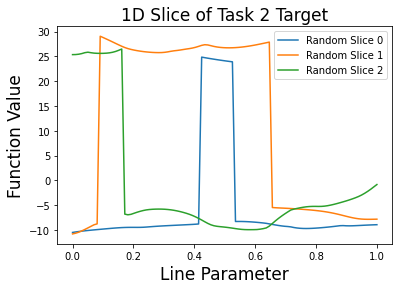

In [85]:
for index in range(0,len(line_elements_list)):
    line_or_path = line_elements_list[index]
    plt.plot(line_parameter, 
             Task_2_Target_Function(line_or_path), 
             label= "Random Slice "+str(index))
    plt.legend()
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('1D Slice of Task 2 Target',fontsize=17)
plt.show()

## Absolute Difference Between Task 1 and Task 2 Target Functions

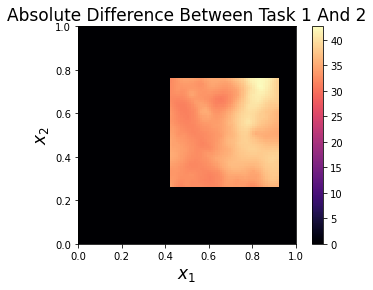

In [86]:
if input_dimension > 1:

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(np.abs(Task_2_Target-Task_1_Target),
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('Absolute Difference Between Task 1 And 2', fontsize=17)
    plt.show()

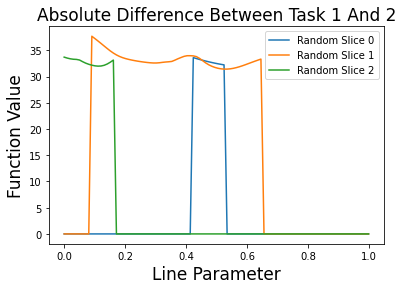

In [87]:
for index in range(0,len(line_elements_list)):
    line_or_path = line_elements_list[index]
    plt.plot(line_parameter, 
             np.abs(Task_2_Target_Function(line_or_path) \
                    -Task_1_Target_Function_RBF(line_or_path)), 
             label= "Random Slice "+str(index))
    plt.legend()
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('Absolute Difference Between Task 1 And 2',fontsize=17)
plt.show()

# Initialise Model With Guaranteed Distal Orthogonality

In [88]:
# Initialise a model

n  = input_dimension
m  = 10
k  = 1#5
r  = 4
h  = 0.
distal_orthogonality = True

model = ATLAS(n, m, r, k, h, distal_orthogonality)
model.construct()
# learning rate close to 0.01 works well.
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=random_learning_rate),
    loss=tf.keras.losses.mean_absolute_error,
    metrics=['mae'])

model.summary()

Model: "atlas_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_24 (Reshape)        multiple                  0         
                                                                 
 conv1d_12 (Conv1D)          multiple                  1         
                                                                 
 activation_10 (Activation)  multiple                  0         
                                                                 
 conv1d_13 (Conv1D)          multiple                  8         
                                                                 
 reshape_25 (Reshape)        multiple                  0         
                                                                 
 repeat_vector_8 (RepeatVect  multiple                 0         
 or)                                                             
                                                           

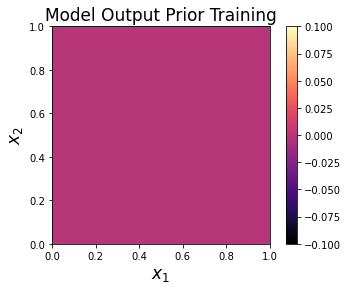

In [89]:
if input_dimension > 1:
    model_prior_training = [model.predict(coordinates).reshape(100,100)]

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(model_prior_training[0],
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('Model Output Prior Training', fontsize=17)
    plt.show()

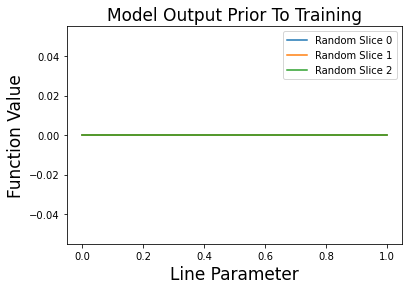

In [90]:
for index in range(0,len(line_elements_list)):
    line_or_path = line_elements_list[index]
    plt.plot(line_parameter, model.predict(line_or_path), label= "Random Slice "+str(index))
    plt.legend()
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('Model Output Prior To Training',fontsize=17)
plt.show()

In [91]:
############################################################################
# Initial Error Estimates Prior to Training on Training Set for Task 1

Task_1_train_initial_MAE =  model.evaluate(Task_1_train_inputs , Task_1_train_output)

Task_1_validation_initial_MAE =  model.evaluate(Task_1_validation_inputs, Task_1_validation_output )

#Task_1_test_initial_MAE = model.evaluate(Task_1_test_inputs, Task_1_test_output )
############################################################################

313/313 [==============================] - 1s 4ms/step - loss: 6.0223 - mae: 6.0223


In [92]:
history_1 = model.fit(Task_1_train_inputs, 
                      Task_1_train_output, 
                      epochs=epochs,
                      verbose=1, 
                      validation_data=( Task_1_validation_inputs , Task_1_validation_output),
                      batch_size=batch_size_param)

Epoch 1/50
100/100 [==============================] - 4s 15ms/step - loss: 5.5376 - mae: 5.5376 - val_loss: 5.0090 - val_mae: 5.0090
Epoch 2/50
100/100 [==============================] - 1s 10ms/step - loss: 4.5802 - mae: 4.5802 - val_loss: 4.1237 - val_mae: 4.1237
Epoch 3/50
100/100 [==============================] - 2s 17ms/step - loss: 3.7616 - mae: 3.7616 - val_loss: 3.3855 - val_mae: 3.3855
Epoch 4/50
100/100 [==============================] - 2s 17ms/step - loss: 3.0559 - mae: 3.0559 - val_loss: 2.6621 - val_mae: 2.6621
Epoch 5/50
100/100 [==============================] - 1s 13ms/step - loss: 2.0677 - mae: 2.0677 - val_loss: 1.7764 - val_mae: 1.7764
Epoch 6/50
100/100 [==============================] - 1s 10ms/step - loss: 1.6856 - mae: 1.6856 - val_loss: 1.6837 - val_mae: 1.6837
Epoch 7/50
100/100 [==============================] - 1s 12ms/step - loss: 1.6050 - mae: 1.6050 - val_loss: 1.6200 - val_mae: 1.6200
Epoch 8/50
100/100 [==============================] - 1s 12ms/step - 

In [93]:
############################################################################
# Error Estimates After Training on Training Set for Task 1

Task_1_train_final_MAE =  model.evaluate(Task_1_train_inputs , Task_1_train_output)

Task_1_validation_final_MAE =  model.evaluate(Task_1_validation_inputs, Task_1_validation_output )

Task_1_test_final_MAE = model.evaluate(Task_1_test_inputs, Task_1_test_output )
############################################################################

313/313 [==============================] - 1s 4ms/step - loss: 0.8389 - mae: 0.8389


In [94]:
Task_1_Training_Loss_Curve = [Task_1_train_initial_MAE[-1]]+history_1.history['mae']
Task_1_Validation_Loss_Curve = [Task_1_validation_initial_MAE[-1]]+history_1.history['val_loss']

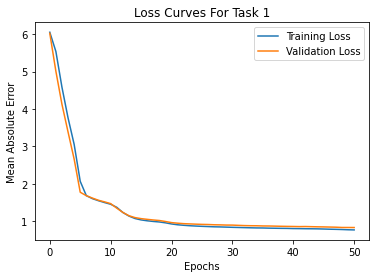

In [95]:
plt.plot(Task_1_Training_Loss_Curve,label='Training Loss')
plt.plot(Task_1_Validation_Loss_Curve,label='Validation Loss')
plt.title('Loss Curves For Task 1')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend()

# 2D Image Comparison Between Model Output and Target 1

## Model Output

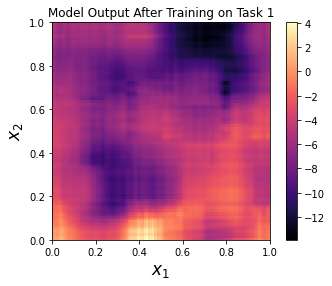

In [96]:
if input_dimension > 1:
    
    
    Task_1_Prediction_After_Training = model.predict(
        coordinates).reshape(100,100)

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_1_Prediction_After_Training,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('Model Output After Training on Task 1')
    plt.show()

## Task 1 Target

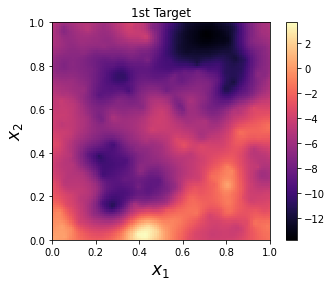

In [97]:
if input_dimension > 1:
    Task_1_Target = Task_1_Target_Function_RBF(coordinates).reshape(100,100)

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_1_Target,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('1st Target')
    plt.show()

# 1D Slice Comparison Between Model Output and Target

## Model Output

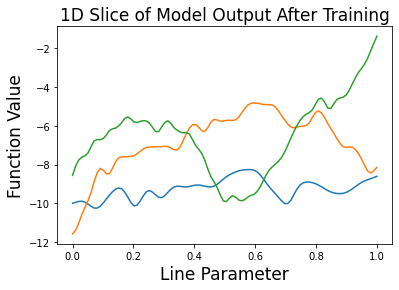

In [98]:
for line_or_path in line_elements_list:
    plt.plot(line_parameter,model.predict(line_or_path))
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('1D Slice of Model Output After Training',fontsize=17)
plt.show()

## Task 1 Target

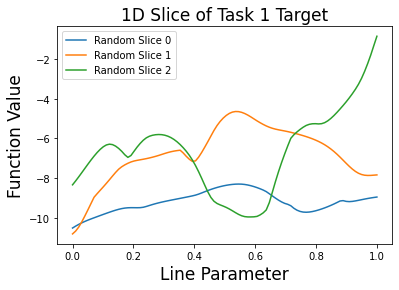

In [99]:
for index in range(0,len(line_elements_list)):
    line_or_path = line_elements_list[index]
    plt.plot(line_parameter, 
             Task_1_Target_Function_RBF(line_or_path), 
             label= "Random Slice "+str(index))
    plt.legend()
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('1D Slice of Task 1 Target',fontsize=17)
plt.show()

# Absolute Difference Between Model Output and Target

## 2D Comparison

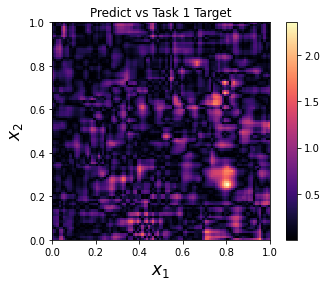

In [100]:
if input_dimension > 1:
    
    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(np.abs(Task_1_Target-Task_1_Prediction_After_Training),
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('Predict vs Task 1 Target')
    plt.show()

## 1D Slice

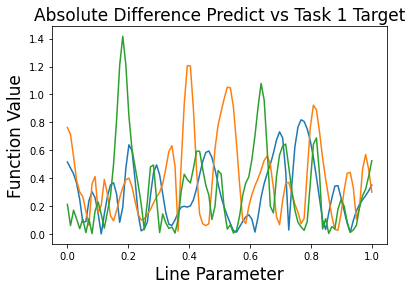

In [101]:
for line_or_path in line_elements_list:
    plt.plot(line_parameter, 
             np.abs(Task_1_Target_Function_RBF(line_or_path).flatten()-\
                    model.predict(line_or_path).flatten()))
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('Absolute Difference Predict vs Task 1 Target',fontsize=17)
plt.show()

# Task 2

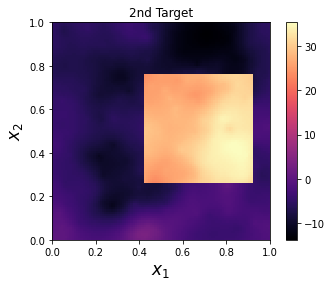

In [102]:
if input_dimension > 1:
    Task_2_Target = Task_2_Target_Function(coordinates).reshape(100,100)

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_2_Target,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('2nd Target')
    plt.show()

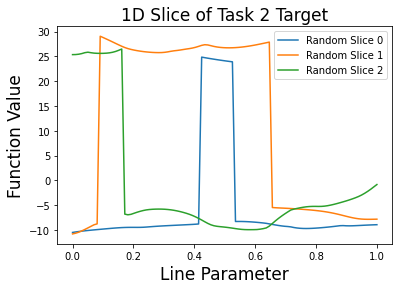

In [103]:
for index in range(0,len(line_elements_list)):
    line_or_path = line_elements_list[index]
    plt.plot(line_parameter, 
             Task_2_Target_Function(line_or_path), 
             label= "Random Slice "+str(index))
    plt.legend()
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('1D Slice of Task 2 Target',fontsize=17)
plt.show()

In [104]:
############################################################################
# Initial Error Estimates Prior to Training on Training Set for Task 2

Task_2_train_initial_MAE =  model.evaluate(Task_2_train_inputs , Task_2_train_output)

Task_2_validation_initial_MAE =  model.evaluate(Task_2_validation_inputs, Task_2_validation_output )

#Task_2_test_initial_MAE = model.evaluate(Task_2_test_inputs, Task_2_test_output )
############################################################################

313/313 [==============================] - 1s 4ms/step - loss: 9.6533 - mae: 9.6533


In [105]:
history_2 = model.fit(Task_2_train_inputs, 
                      Task_2_train_output, 
                      epochs=epochs,
                      verbose=1, 
                      validation_data=( Task_2_validation_inputs , Task_2_validation_output),
                      batch_size=batch_size_param)

Epoch 1/50
100/100 [==============================] - 1s 10ms/step - loss: 30.8252 - mae: 30.8252 - val_loss: 8.7863 - val_mae: 8.7863
Epoch 2/50
100/100 [==============================] - 1s 11ms/step - loss: 20.1024 - mae: 20.1024 - val_loss: 7.6247 - val_mae: 7.6247
Epoch 3/50
100/100 [==============================] - 1s 11ms/step - loss: 12.2645 - mae: 12.2645 - val_loss: 5.9401 - val_mae: 5.9401
Epoch 4/50
100/100 [==============================] - 1s 9ms/step - loss: 3.5408 - mae: 3.5408 - val_loss: 4.6219 - val_mae: 4.6219
Epoch 5/50
100/100 [==============================] - 1s 12ms/step - loss: 1.1270 - mae: 1.1270 - val_loss: 4.6581 - val_mae: 4.6581
Epoch 6/50
100/100 [==============================] - 1s 11ms/step - loss: 0.9914 - mae: 0.9914 - val_loss: 4.6613 - val_mae: 4.6613
Epoch 7/50
100/100 [==============================] - 1s 12ms/step - loss: 0.9204 - mae: 0.9204 - val_loss: 4.6573 - val_mae: 4.6573
Epoch 8/50
100/100 [==============================] - 1s 12ms/st

In [106]:
############################################################################
# Error Estimates After Training on Training Set for Task 2

Task_2_train_final_MAE =  model.evaluate(Task_2_train_inputs , Task_2_train_output)

Task_2_validation_final_MAE =  model.evaluate(Task_2_validation_inputs, Task_2_validation_output )

Task_2_test_final_MAE = model.evaluate(Task_2_test_inputs, Task_2_test_output )
############################################################################

313/313 [==============================] - 2s 5ms/step - loss: 5.0058 - mae: 5.0058


In [107]:
Task_2_Training_Loss_Curve = [Task_2_train_initial_MAE[-1]]+history_2.history['mae']
Task_2_Validation_Loss_Curve = [Task_2_validation_initial_MAE[-1]]+history_2.history['val_loss']

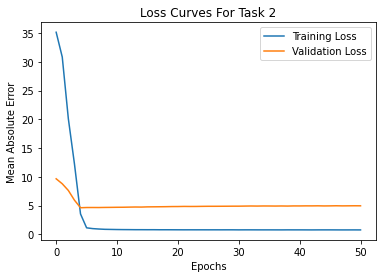

In [108]:
plt.plot(Task_2_Training_Loss_Curve,label='Training Loss')
plt.plot(Task_2_Validation_Loss_Curve,label='Validation Loss')
#"Epochs", ylabel="MAE")
plt.title('Loss Curves For Task 2')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend()

# 2D Image Comparison Between Model Output and Target 2

## Model Output

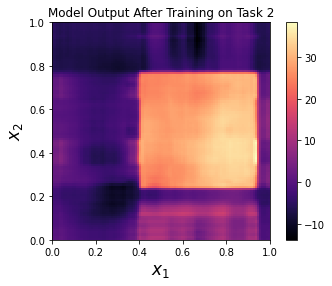

In [109]:
if input_dimension > 1:
    Task_2_Prediction_After_Training = model.predict(
        coordinates).reshape(100,100)

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_2_Prediction_After_Training,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('Model Output After Training on Task 2')
    plt.show()

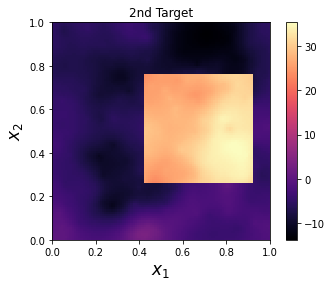

In [110]:
if input_dimension > 1:
    Task_2_Target = Task_2_Target_Function(coordinates).reshape(100,100)

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_2_Target,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('2nd Target')
    plt.show()

# 1D Slice Comparison Between Model Output and Target 2

## Model Output

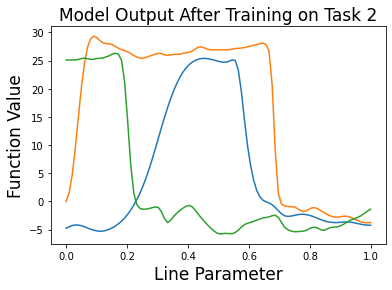

In [111]:
for line_or_path in line_elements_list:
    plt.plot(line_parameter,model.predict(line_or_path))
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('Model Output After Training on Task 2',fontsize=17)
plt.show()

## Task 2 Target

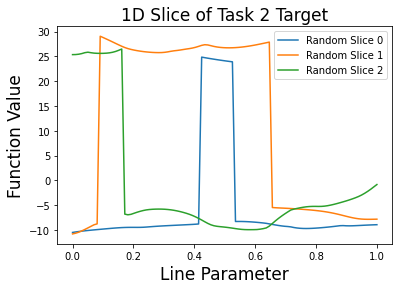

In [112]:
for index in range(0,len(line_elements_list)):
    line_or_path = line_elements_list[index]
    plt.plot(line_parameter, 
             Task_2_Target_Function(line_or_path), 
             label= "Random Slice "+str(index))
    plt.legend()
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('1D Slice of Task 2 Target',fontsize=17)
plt.show()

# Absolute Difference Between Model Output and Task 2 Target 

## 2D Comparison

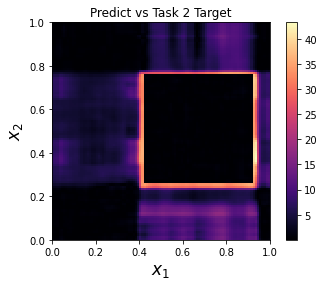

In [113]:
if input_dimension > 1:
    Task_2_Target_vs_Output = np.abs(Task_2_Target-\
                                     Task_2_Prediction_After_Training)
    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_2_Target_vs_Output,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('Predict vs Task 2 Target')
    plt.show()

## 1D Slice

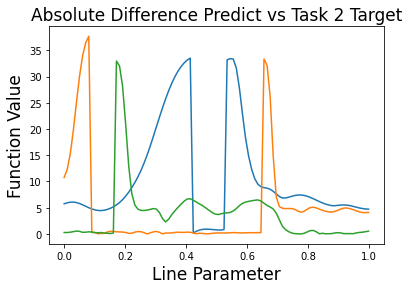

In [114]:
for line_or_path in line_elements_list:

    plt.plot(line_parameter, 
             np.abs(Task_2_Target_Function(line_or_path).flatten()-\
                    model.predict(line_or_path).flatten()))
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('Absolute Difference Predict vs Task 2 Target',fontsize=17)
plt.show()

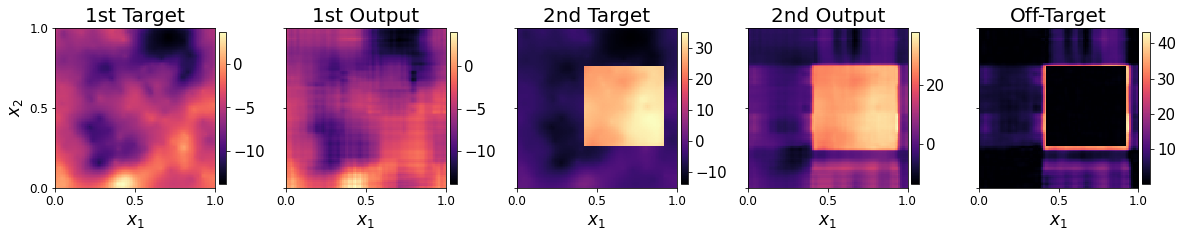

In [115]:
if input_dimension >1:
    images_to_plot = [Task_1_Target,
                      Task_1_Prediction_After_Training,
                      Task_2_Target,
                      Task_2_Prediction_After_Training,
                      Task_2_Target_vs_Output]

    # images_to_plot list
    num_rows = 1
    num_cols = 1
    interpol = 'none' # 'nearest'
    xticks = [0,0.5,1] #[0,0.25,0.5,0.75,1]
    yticks = [0,0.5,1]
    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3] # 'inferno'
    subplot_titles = ['1st Target','1st Output','2nd Target','2nd Output','Off-Target'] #['a','b','c','d','e']

    fig, axs = plt.subplots(1, 5, sharex='col', sharey='row',figsize=(20,4))
    #fig.tight_layout()

    for col in range(5):    
        ax = axs[col]
        ax.set_title(subplot_titles[col],fontsize=20)
        ax.set_aspect(1)
        ax.set_xlabel(r'$x_{1}$',fontsize=17)
        ax.set_xticks(xticks)
        ax.tick_params(axis='x', which='major', labelsize=12)

        if col==0:
            ax.set_ylabel(r'$x_{2}$',fontsize=17)
            ax.set_yticks(yticks)
            ax.tick_params(axis='y', which='major', labelsize=12)
        pcm = ax.imshow(images_to_plot[col], cmap=cmaps, interpolation='none', extent=[0.,1,0.,1.],origin='lower')
        #pcm.set_clim(np.min(images_to_plot),np.max(images_to_plot))
        #pcm.set_clim(-10.,12.)
        #cb = fig.colorbar(pcm, ax=axs, shrink=0.7, ticks=[-1, -0.5, 0, 0.5, 1, 1.5, 2], pad=0.02, aspect=10)
        #cb = fig.colorbar(pcm, ax=axs, shrink=0.7, pad=0.02, aspect=10)
        cb = fig.colorbar(pcm, ax=axs[col], shrink=0.7, pad=0.02, aspect=20,location='right')
        #cb.set_label(r'$y(x_{1}, x_{2})$', labelpad=10, size=20)
        #if col==4:
        #    cb.set_label(r'Function Value', labelpad=10, size=18)
        cb.ax.tick_params(labelsize=15)

    #fig.savefig(output_dir+"memory_retention_visualisation/memory_retention_visualisation"+str(index_value)+".png", 
    #            close = True, verbose = True, dpi=500,bbox_inches='tight')

    plt.show()

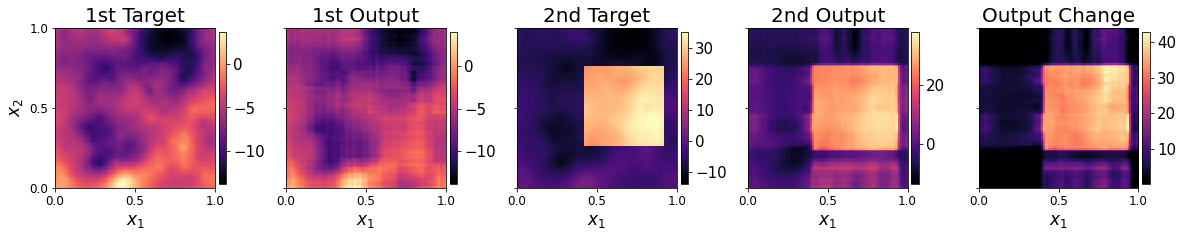

In [116]:
if input_dimension > 1:
    images_to_plot = [Task_1_Target,
                      Task_1_Prediction_After_Training,
                      Task_2_Target,
                      Task_2_Prediction_After_Training,
                      np.abs(Task_1_Prediction_After_Training-Task_2_Prediction_After_Training)]

    # images_to_plot list
    num_rows = 1
    num_cols = 1
    interpol = 'none' # 'nearest'
    xticks = [0,0.5,1] #[0,0.25,0.5,0.75,1]
    yticks = [0,0.5,1]
    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3] # 'inferno'
    subplot_titles = ['1st Target','1st Output','2nd Target','2nd Output','Output Change'] #['a','b','c','d','e']

    fig, axs = plt.subplots(1, 5, sharex='col', sharey='row',figsize=(20,4))
    #fig.tight_layout()

    for col in range(5):    
        ax = axs[col]
        ax.set_title(subplot_titles[col],fontsize=20)
        ax.set_aspect(1)
        ax.set_xlabel(r'$x_{1}$',fontsize=17)
        ax.set_xticks(xticks)
        ax.tick_params(axis='x', which='major', labelsize=12)

        if col==0:
            ax.set_ylabel(r'$x_{2}$',fontsize=17)
            ax.set_yticks(yticks)
            ax.tick_params(axis='y', which='major', labelsize=12)
        pcm = ax.imshow(images_to_plot[col], cmap=cmaps, interpolation='none', extent=[0.,1,0.,1.],origin='lower')
        #pcm.set_clim(np.min(images_to_plot),np.max(images_to_plot))
        #pcm.set_clim(-10.,12.)
        #cb = fig.colorbar(pcm, ax=axs, shrink=0.7, ticks=[-1, -0.5, 0, 0.5, 1, 1.5, 2], pad=0.02, aspect=10)
        #cb = fig.colorbar(pcm, ax=axs, shrink=0.7, pad=0.02, aspect=10)
        cb = fig.colorbar(pcm, ax=axs[col], shrink=0.7, pad=0.02, aspect=20,location='right')
        #cb.set_label(r'$y(x_{1}, x_{2})$', labelpad=10, size=20)
        #if col==4:
        #    cb.set_label(r'Function Value', labelpad=10, size=18)
        cb.ax.tick_params(labelsize=15)

    #fig.savefig(output_dir+"memory_retention_visualisation/memory_retention_visualisation"+str(index_value)+".png", 
    #            close = True, verbose = True, dpi=500,bbox_inches='tight')

    plt.show()

# Without Distal Orthogonality


In [117]:
# Initialise a model

n  = input_dimension
m  = 10
k  = 1#5
r  = 4
h  = 0.
distal_orthogonality = False

model = ATLAS(n, m, r, k, h, distal_orthogonality)
model.construct()
# learning rate close to 0.01 works well.
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=random_learning_rate),
    loss=tf.keras.losses.mean_absolute_error,
    metrics=['mae'])

model.summary()

Model: "atlas_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_36 (Reshape)        multiple                  0         
                                                                 
 conv1d_18 (Conv1D)          multiple                  1         
                                                                 
 activation_15 (Activation)  multiple                  0         
                                                                 
 conv1d_19 (Conv1D)          multiple                  8         
                                                                 
 reshape_37 (Reshape)        multiple                  0         
                                                                 
 repeat_vector_12 (RepeatVec  multiple                 0         
 tor)                                                            
                                                           

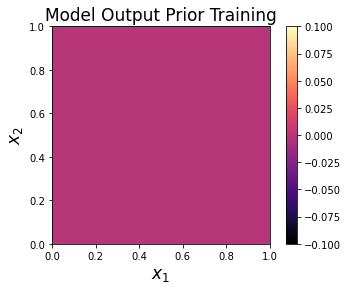

In [118]:
if input_dimension > 1:
    model_prior_training = [model.predict(coordinates).reshape(100,100)]

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(model_prior_training[0],
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('Model Output Prior Training', fontsize=17)
    plt.show()

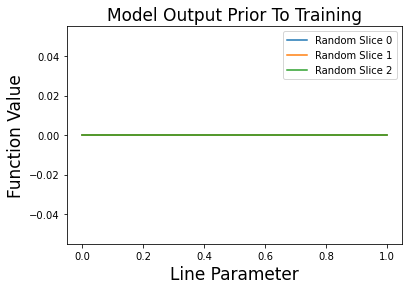

In [119]:
for index in range(0,len(line_elements_list)):
    line_or_path = line_elements_list[index]
    plt.plot(line_parameter, model.predict(line_or_path), label= "Random Slice "+str(index))
    plt.legend()
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('Model Output Prior To Training',fontsize=17)
plt.show()

In [120]:
############################################################################
# Initial Error Estimates Prior to Training on Training Set

Task_1_train_initial_MAE =  model.evaluate(Task_1_train_inputs , Task_1_train_output)

Task_1_validation_initial_MAE =  model.evaluate(Task_1_validation_inputs, Task_1_validation_output )

#Task_1_test_initial_MAE = model.evaluate(Task_1_test_inputs, Task_1_test_output )
############################################################################

313/313 [==============================] - 2s 5ms/step - loss: 6.0223 - mae: 6.0223


In [121]:
history_1 = model.fit(Task_1_train_inputs, 
                      Task_1_train_output, 
                      epochs=epochs,
                      verbose=1, 
                      validation_data=( Task_1_validation_inputs , Task_1_validation_output),
                      batch_size=batch_size_param)

Epoch 1/50
100/100 [==============================] - 3s 16ms/step - loss: 3.8007 - mae: 3.8007 - val_loss: 2.1840 - val_mae: 2.1840
Epoch 2/50
100/100 [==============================] - 1s 13ms/step - loss: 1.6400 - mae: 1.6400 - val_loss: 1.4301 - val_mae: 1.4301
Epoch 3/50
100/100 [==============================] - 1s 14ms/step - loss: 1.2438 - mae: 1.2438 - val_loss: 1.1091 - val_mae: 1.1091
Epoch 4/50
100/100 [==============================] - 1s 13ms/step - loss: 1.0254 - mae: 1.0254 - val_loss: 1.0094 - val_mae: 1.0094
Epoch 5/50
100/100 [==============================] - 1s 13ms/step - loss: 0.9282 - mae: 0.9282 - val_loss: 0.9318 - val_mae: 0.9318
Epoch 6/50
100/100 [==============================] - 1s 13ms/step - loss: 0.8655 - mae: 0.8655 - val_loss: 0.8600 - val_mae: 0.8600
Epoch 7/50
100/100 [==============================] - 1s 14ms/step - loss: 0.8202 - mae: 0.8202 - val_loss: 0.8461 - val_mae: 0.8461
Epoch 8/50
100/100 [==============================] - 1s 13ms/step - 

In [122]:
############################################################################
# Initial Error Estimates After Training on Training Set for Task 1

Task_1_train_final_MAE =  model.evaluate(Task_1_train_inputs , Task_1_train_output)

Task_1_validation_final_MAE =  model.evaluate(Task_1_validation_inputs, Task_1_validation_output )

Task_1_test_final_MAE = model.evaluate(Task_1_test_inputs, Task_1_test_output )
############################################################################

313/313 [==============================] - 2s 5ms/step - loss: 0.8068 - mae: 0.8068


In [123]:
Task_1_Training_Loss_Curve = [Task_1_train_initial_MAE[-1]]+history_1.history['mae']
Task_1_Validation_Loss_Curve = [Task_1_validation_initial_MAE[-1]]+history_1.history['val_loss']

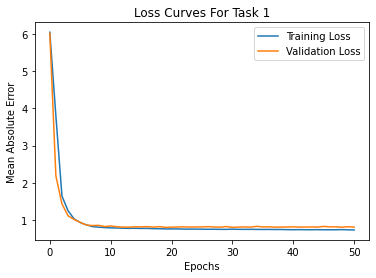

In [124]:
plt.plot(Task_1_Training_Loss_Curve,label='Training Loss')
plt.plot(Task_1_Validation_Loss_Curve,label='Validation Loss')
plt.title('Loss Curves For Task 1')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend()

# 2D Image Comparison Between Model Output and Target 1

## Model Output

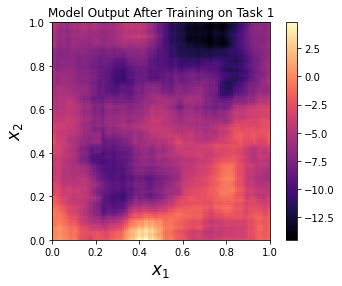

In [125]:
if input_dimension > 1:
    
    
    Task_1_Prediction_After_Training = model.predict(
        coordinates).reshape(100,100)

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_1_Prediction_After_Training,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('Model Output After Training on Task 1')
    plt.show()

## Task 1 Target

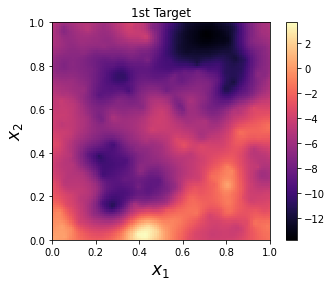

In [126]:
if input_dimension > 1:
    Task_1_Target = Task_1_Target_Function_RBF(coordinates).reshape(100,100)

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_1_Target,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('1st Target')
    plt.show()

# 1D Slice Comparison Between Model Output and Target

## Model Output

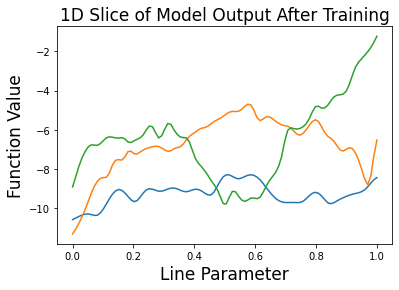

In [127]:
for line_or_path in line_elements_list:
    plt.plot(line_parameter,model.predict(line_or_path))
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('1D Slice of Model Output After Training',fontsize=17)
plt.show()

## Task 1 Target

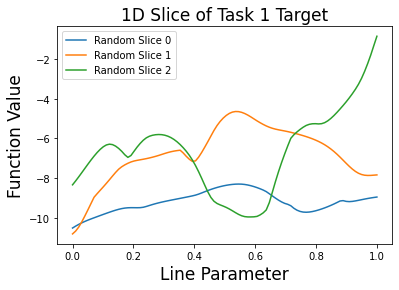

In [128]:
for index in range(0,len(line_elements_list)):
    line_or_path = line_elements_list[index]
    plt.plot(line_parameter, 
             Task_1_Target_Function_RBF(line_or_path), 
             label= "Random Slice "+str(index))
    plt.legend()
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('1D Slice of Task 1 Target',fontsize=17)
plt.show()

# Absolute Difference Between Model Output and Target

## 2D Comparison

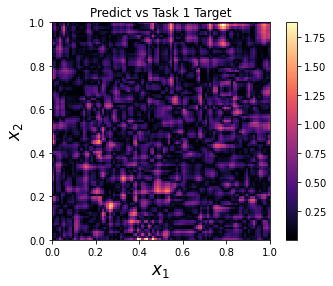

In [129]:
if input_dimension > 1:
    
    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(np.abs(Task_1_Target-Task_1_Prediction_After_Training),
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('Predict vs Task 1 Target')
    plt.show()

## 1D Slice

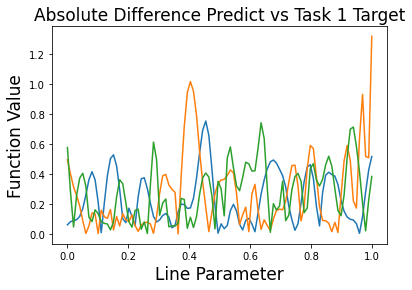

In [130]:
for line_or_path in line_elements_list:
    plt.plot(line_parameter, 
             np.abs(Task_1_Target_Function_RBF(line_or_path).flatten()-\
                    model.predict(line_or_path).flatten()))
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('Absolute Difference Predict vs Task 1 Target',fontsize=17)
plt.show()

# Task 2

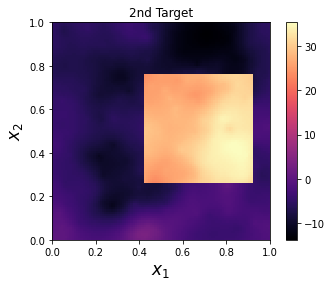

In [131]:
if input_dimension > 1:
    Task_2_Target = Task_2_Target_Function(coordinates).reshape(100,100)

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_2_Target,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('2nd Target')
    plt.show()

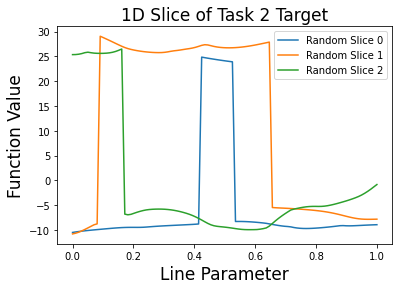

In [132]:
for index in range(0,len(line_elements_list)):
    line_or_path = line_elements_list[index]
    plt.plot(line_parameter, 
             Task_2_Target_Function(line_or_path), 
             label= "Random Slice "+str(index))
    plt.legend()
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('1D Slice of Task 2 Target',fontsize=17)
plt.show()

In [133]:
############################################################################
# Initial Error Estimates Prior to Training on Training Set

Task_2_train_initial_MAE =  model.evaluate(Task_2_train_inputs , Task_2_train_output)

Task_2_validation_initial_MAE =  model.evaluate(Task_2_validation_inputs, Task_2_validation_output )

#Task_2_test_initial_MAE = model.evaluate(Task_2_test_inputs, Task_2_test_output )
############################################################################

313/313 [==============================] - 2s 5ms/step - loss: 9.6178 - mae: 9.6178


In [134]:
history_2 = model.fit(Task_2_train_inputs, 
                      Task_2_train_output, 
                      epochs=epochs,
                      verbose=1, 
                      validation_data=( Task_2_validation_inputs , Task_2_validation_output),
                      batch_size=batch_size_param)

Epoch 1/50
100/100 [==============================] - 2s 22ms/step - loss: 14.6072 - mae: 14.6072 - val_loss: 9.1431 - val_mae: 9.1431
Epoch 2/50
100/100 [==============================] - 1s 14ms/step - loss: 1.0499 - mae: 1.0499 - val_loss: 9.2053 - val_mae: 9.2053
Epoch 3/50
100/100 [==============================] - 1s 12ms/step - loss: 0.9183 - mae: 0.9183 - val_loss: 9.2745 - val_mae: 9.2745
Epoch 4/50
100/100 [==============================] - 1s 13ms/step - loss: 0.8486 - mae: 0.8486 - val_loss: 9.3542 - val_mae: 9.3542
Epoch 5/50
100/100 [==============================] - 1s 13ms/step - loss: 0.8545 - mae: 0.8545 - val_loss: 9.3916 - val_mae: 9.3916
Epoch 6/50
100/100 [==============================] - 1s 13ms/step - loss: 0.8297 - mae: 0.8297 - val_loss: 9.4779 - val_mae: 9.4779
Epoch 7/50
100/100 [==============================] - 1s 13ms/step - loss: 0.8232 - mae: 0.8232 - val_loss: 9.5028 - val_mae: 9.5028
Epoch 8/50
100/100 [==============================] - 1s 13ms/step 

In [135]:
############################################################################
# Initial Error Estimates Prior to Training on Training Set

Task_2_train_final_MAE =  model.evaluate(Task_2_train_inputs , Task_2_train_output)

Task_2_validation_final_MAE =  model.evaluate(Task_2_validation_inputs, Task_2_validation_output )

Task_2_test_final_MAE = model.evaluate(Task_2_test_inputs, Task_2_test_output )
############################################################################

313/313 [==============================] - 1s 4ms/step - loss: 12.0287 - mae: 12.0287


In [136]:
Task_2_Training_Loss_Curve = [Task_2_train_initial_MAE[-1]]+history_2.history['mae']
Task_2_Validation_Loss_Curve = [Task_2_validation_initial_MAE[-1]]+history_2.history['val_loss']

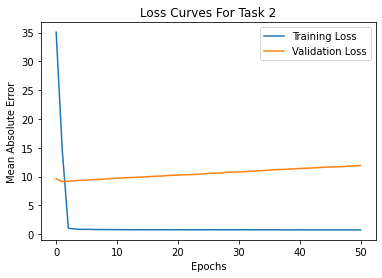

In [137]:
plt.plot(Task_2_Training_Loss_Curve,label='Training Loss')
plt.plot(Task_2_Validation_Loss_Curve,label='Validation Loss')
#"Epochs", ylabel="MAE")
plt.title('Loss Curves For Task 2')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend()

# 2D Image Comparison Between Model Output and Target 2

## Model Output

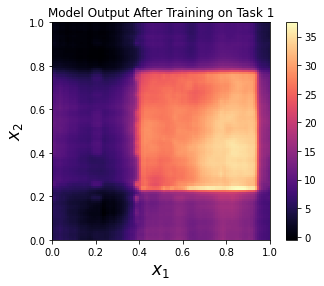

In [138]:
if input_dimension > 1:
    Task_2_Prediction_After_Training = model.predict(
        coordinates).reshape(100,100)

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_2_Prediction_After_Training,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('Model Output After Training on Task 1')
    plt.show()

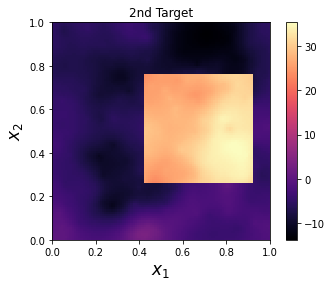

In [139]:
if input_dimension > 1:
    Task_2_Target = Task_2_Target_Function(coordinates).reshape(100,100)

    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_2_Target,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('2nd Target')
    plt.show()

# 1D Slice Comparison Between Model Output and Target 2

## Model Output

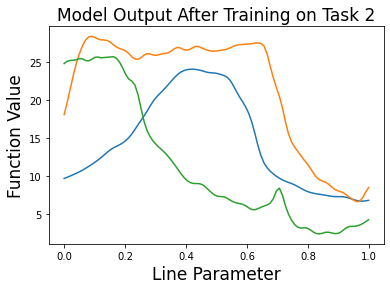

In [140]:
for line_or_path in line_elements_list:
    plt.plot(line_parameter,model.predict(line_or_path))
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('Model Output After Training on Task 2',fontsize=17)
plt.show()

## Task 2 Target

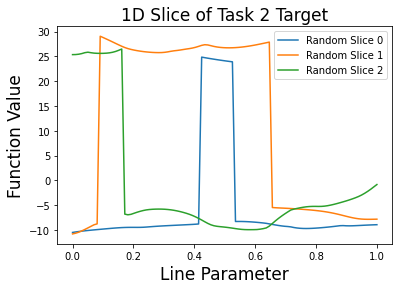

In [141]:
for index in range(0,len(line_elements_list)):
    line_or_path = line_elements_list[index]
    plt.plot(line_parameter, 
             Task_2_Target_Function(line_or_path), 
             label= "Random Slice "+str(index))
    plt.legend()
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('1D Slice of Task 2 Target',fontsize=17)
plt.show()

# Absolute Difference Between Model Output and Task 2 Target 

## 2D Comparison

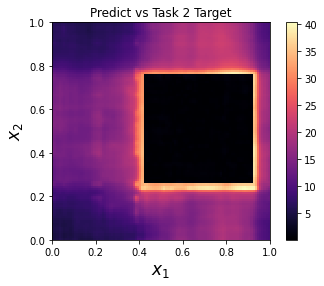

In [142]:
if input_dimension > 1:
    Task_2_Target_vs_Output = np.abs(Task_2_Target-\
                                     Task_2_Prediction_After_Training)
    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3]
    plt.imshow(Task_2_Target_vs_Output,
               origin='lower', 
               cmap=cmaps, 
               interpolation='none', 
               extent=[0.,1,0.,1.])
    plt.colorbar()
    plt.ylabel(r'$x_{2}$',fontsize=17)
    plt.xlabel(r'$x_{1}$',fontsize=17)
    plt.title('Predict vs Task 2 Target')
    plt.show()

## 1D Slice

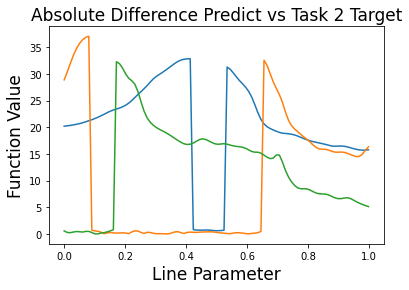

In [143]:
for line_or_path in line_elements_list:

    plt.plot(line_parameter, 
             np.abs(Task_2_Target_Function(line_or_path).flatten()-\
                    model.predict(line_or_path).flatten()))
    
plt.ylabel('Function Value',fontsize=17)
plt.xlabel('Line Parameter',fontsize=17)
plt.title('Absolute Difference Predict vs Task 2 Target',fontsize=17)
plt.show()

# Collection of Images for Visual Inspection

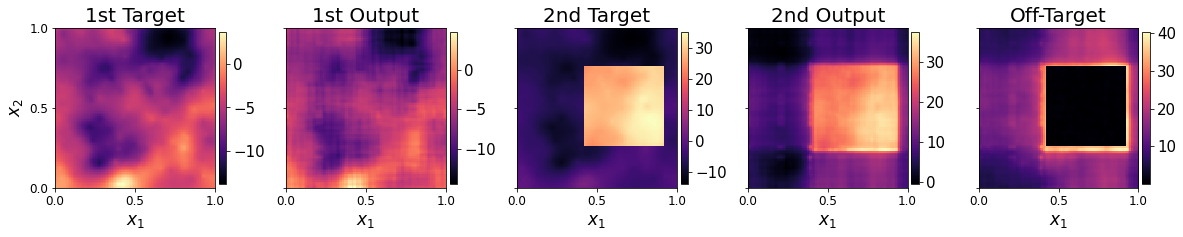

In [144]:
if input_dimension >1:
    images_to_plot = [Task_1_Target,
                      Task_1_Prediction_After_Training,
                      Task_2_Target,
                      Task_2_Prediction_After_Training,
                      Task_2_Target_vs_Output]

    # images_to_plot list
    num_rows = 1
    num_cols = 1
    interpol = 'none' # 'nearest'
    xticks = [0,0.5,1] #[0,0.25,0.5,0.75,1]
    yticks = [0,0.5,1]
    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3] # 'inferno'
    subplot_titles = ['1st Target','1st Output','2nd Target','2nd Output','Off-Target'] #['a','b','c','d','e']

    fig, axs = plt.subplots(1, 5, sharex='col', sharey='row',figsize=(20,4))
    #fig.tight_layout()

    for col in range(5):    
        ax = axs[col]
        ax.set_title(subplot_titles[col],fontsize=20)
        ax.set_aspect(1)
        ax.set_xlabel(r'$x_{1}$',fontsize=17)
        ax.set_xticks(xticks)
        ax.tick_params(axis='x', which='major', labelsize=12)

        if col==0:
            ax.set_ylabel(r'$x_{2}$',fontsize=17)
            ax.set_yticks(yticks)
            ax.tick_params(axis='y', which='major', labelsize=12)
        pcm = ax.imshow(images_to_plot[col], cmap=cmaps, interpolation='none', extent=[0.,1,0.,1.],origin='lower')
        #pcm.set_clim(np.min(images_to_plot),np.max(images_to_plot))
        #pcm.set_clim(-10.,12.)
        #cb = fig.colorbar(pcm, ax=axs, shrink=0.7, ticks=[-1, -0.5, 0, 0.5, 1, 1.5, 2], pad=0.02, aspect=10)
        #cb = fig.colorbar(pcm, ax=axs, shrink=0.7, pad=0.02, aspect=10)
        cb = fig.colorbar(pcm, ax=axs[col], shrink=0.7, pad=0.02, aspect=20,location='right')
        #cb.set_label(r'$y(x_{1}, x_{2})$', labelpad=10, size=20)
        #if col==4:
        #    cb.set_label(r'Function Value', labelpad=10, size=18)
        cb.ax.tick_params(labelsize=15)

    #fig.savefig(output_dir+"memory_retention_visualisation/memory_retention_visualisation"+str(index_value)+".png", 
    #            close = True, verbose = True, dpi=500,bbox_inches='tight')

    plt.show()

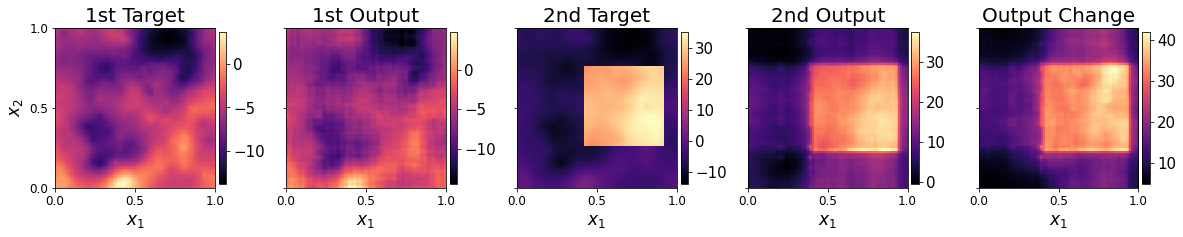

In [145]:
if input_dimension > 1:
    images_to_plot = [Task_1_Target,
                      Task_1_Prediction_After_Training,
                      Task_2_Target,
                      Task_2_Prediction_After_Training,
                      np.abs(Task_1_Prediction_After_Training-Task_2_Prediction_After_Training)]

    # images_to_plot list
    num_rows = 1
    num_cols = 1
    interpol = 'none' # 'nearest'
    xticks = [0,0.5,1] #[0,0.25,0.5,0.75,1]
    yticks = [0,0.5,1]
    cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis'][3] # 'inferno'
    subplot_titles = ['1st Target','1st Output','2nd Target','2nd Output','Output Change'] #['a','b','c','d','e']

    fig, axs = plt.subplots(1, 5, sharex='col', sharey='row',figsize=(20,4))
    #fig.tight_layout()

    for col in range(5):    
        ax = axs[col]
        ax.set_title(subplot_titles[col],fontsize=20)
        ax.set_aspect(1)
        ax.set_xlabel(r'$x_{1}$',fontsize=17)
        ax.set_xticks(xticks)
        ax.tick_params(axis='x', which='major', labelsize=12)

        if col==0:
            ax.set_ylabel(r'$x_{2}$',fontsize=17)
            ax.set_yticks(yticks)
            ax.tick_params(axis='y', which='major', labelsize=12)
        pcm = ax.imshow(images_to_plot[col], cmap=cmaps, interpolation='none', extent=[0.,1,0.,1.],origin='lower')
        #pcm.set_clim(np.min(images_to_plot),np.max(images_to_plot))
        #pcm.set_clim(-10.,12.)
        #cb = fig.colorbar(pcm, ax=axs, shrink=0.7, ticks=[-1, -0.5, 0, 0.5, 1, 1.5, 2], pad=0.02, aspect=10)
        #cb = fig.colorbar(pcm, ax=axs, shrink=0.7, pad=0.02, aspect=10)
        cb = fig.colorbar(pcm, ax=axs[col], shrink=0.7, pad=0.02, aspect=20,location='right')
        #cb.set_label(r'$y(x_{1}, x_{2})$', labelpad=10, size=20)
        #if col==4:
        #    cb.set_label(r'Function Value', labelpad=10, size=18)
        cb.ax.tick_params(labelsize=15)

    #fig.savefig(output_dir+"memory_retention_visualisation/memory_retention_visualisation"+str(index_value)+".png", 
    #            close = True, verbose = True, dpi=500,bbox_inches='tight')

    plt.show()